In [1]:
import math
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from my_ecog_utils import read_with_annotations, get_multitaper_power_bands

## Power Calcs

In [2]:
pts_w_any_stim = [100, 103, 105, 106, 109, 110, 111, 112, 113, 115, 202]
freqs = ['Delta', 'Theta', 'Alpha', 'Beta', 'GammaLow', 'GammaHigh']

In [3]:
results_before_after = pd.DataFrame(columns=['ID', 'Stim', 'Trial', 'Channel', 'Delta', 'Theta', 'Alpha', 'Beta'])
results_before_after.loc[:,'Stim'] = results_before_after['Stim'].astype('bool')

for pt_num in pts_w_any_stim:
    raw = read_with_annotations(pt_num)
    if pt_num in [100, 103, 112, 115]:
        raw.load_data()
        raw.notch_filter(62.5)

    evts, event_id = mne.events_from_annotations(raw, {'BAD_': 0, 'post_shock': 2, 'pre_shock': 1})
    epochs = mne.Epochs(raw, evts, event_id=event_id, tmin=0, tmax=1, baseline=(0.5,1.0))

    if pt_num == 100:
        epochs.rename_channels({'Hip1 - Hip2': 'LHip1 - LHip2', 'Hip3 - Hip4': 'LHip3 - LHip4'})
    elif pt_num == 113:
        epochs.rename_channels(lambda s: s.replace('H', 'Hip'))

    # drop segments that overlap with shocks
    # i.e. those that are shorter than 1 second. May change tmax in the future
    epochs.drop_bad()
    
    # if you ever need to debug, look at the drop logs
    print(epochs.drop_log)
    trial_num = 0
    epoch_num = 0
    shock_num = 1
    for i in range(len(epochs.drop_log)):
        epoch = epochs[epoch_num]
        shock_num += 1
        if epochs.drop_log[i] == ('BAD_',):
            continue
        is_post_stim = 'post_shock' in epoch.event_id
        if not is_post_stim:
            trial_num += 1
            shock_num = 0
        for chan in epochs.ch_names:
            powers = get_multitaper_power_bands(epoch, picks=chan, split_gamma=True)
            results_before_after = results_before_after.append({'ID': pt_num, 'Stim': is_post_stim, 'Trial': trial_num, 'Channel': chan, 'Stim_Num': shock_num, **powers}, ignore_index=True)
        epoch_num += 1

results_before_after.to_csv('power_two_gamma_bands_100.csv', index=False)
results_before_after

Opening raw data file data/100/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 51647 =      0.000 ...   206.588 secs
Ready.
Reading 0 ... 51647  =      0.000 ...   206.588 secs...
Setting up band-stop filter from 62 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 61.84
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.59 Hz)
- Upper passband edge: 63.16 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 63.41 Hz)
- Filter length: 1651 samples (6.604 sec)



KeyboardInterrupt: 

In [4]:
results_before_after = pd.read_csv('power_two_gamma_bands.csv')

In [5]:
results_before_after['Stim_Num'] = results_before_after['Stim_Num'].astype(int)

baselines = results_before_after[results_before_after['Stim'] == False]
stims = results_before_after[results_before_after['Stim'] == True]
rearranged = stims.merge(baselines, on=['ID', 'Trial', 'Channel'], suffixes=['_post', '_pre'])
rearranged = rearranged.drop(['Stim_post', 'Stim_pre'], axis='columns')

for freq in freqs:
    rearranged[freq+'_pct'] = (rearranged[freq+'_post'] - rearranged[freq+'_pre']) / rearranged[freq+'_pre'] * 100

In [6]:
power_log_chg = rearranged.copy()
for freq in freqs:
    power_log_chg = power_log_chg.drop(freq+'_pct', axis=1)
    power_log_chg[freq+'_log_chg'] = np.log10(rearranged[freq+'_post']) - np.log10(rearranged[freq+'_pre'])
power_log_chg = power_log_chg.drop('Stim_Num_pre', axis=1).rename({'Stim_Num_post': 'Stim_Num'}, axis=1)
power_log_chg

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100      1  LHip1 - LHip2  1.100502e-07  7.161263e-08  2.537439e-08   
1    100      1  LHip1 - LHip2  5.257047e-08  3.228662e-08  2.086371e-08   
2    100      1  LHip1 - LHip2  4.163676e-08  3.540437e-08  3.576591e-08   
3    100      1  LHip1 - LHip2  8.662249e-08  8.010154e-08  4.598185e-08   
4    100      1  LHip3 - LHip4  3.511744e-07  7.526684e-08  5.945997e-09   
..   ...    ...            ...           ...           ...           ...   
495  202      3    LHT1 - LHT2  3.267524e-09  1.279668e-09  7.131607e-10   
496  202      3    LHT3 - LHT4  5.688727e-09  1.662203e-09  7.292102e-10   
497  202      3    LHT3 - LHT4  1.083823e-08  1.126939e-09  8.131701e-10   
498  202      3    LHT3 - LHT4  9.217661e-09  8.687519e-10  1.712772e-09   
499  202      3    LHT3 - LHT4  1.327379e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  Stim_Num  ...     Alpha_pre  \
0    1.169223e-08    2.386223e-10   9.902345e-10         1  ...  3.897899e-08   
1    8.328850e-09    2.321038e-10   1.225056e-09         2  ...  3.897899e-08   
2    1.402683e-08    1.753604e-10   9.843672e-10         3  ...  3.897899e-08   
3    9.420390e-09    1.176374e-10   5.373972e-10         4  ...  3.897899e-08   
4    3.396220e-09    1.250363e-10   8.468632e-10         1  ...  7.955522e-09   
..            ...             ...            ...       ...  ...           ...   
495  4.481172e-10    2.311009e-11   9.922757e-11         6  ...  1.437852e-09   
496  4.810947e-10    2.270675e-11   3.770633e-11         2  ...  1.598375e-09   
497  4.845502e-10    1.739176e-11   6.965751e-11         3  ...  1.598375e-09   
498  5.998392e-10    1.531352e-11   4.582474e-11         4  ...  1.598375e-09   
499  3.662438e-10    1.498472e-11   5.989246e-11         6  ...  1.598375e-09   

         Beta_pre  GammaHigh_pre  GammaLow_pre  Delta_log_chg  Theta_log_chg  \
0    1.350653e-08   2.164951e-10  1.014126e-09       0.228848      -0.046258   
1    1.350653e-08   2.164951e-10  1.014126e-09      -0.092001      -0.392225   
2    1.350653e-08   2.164951e-10  1.014126e-09      -0.193266      -0.352190   
3    1.350653e-08   2.164951e-10  1.014126e-09       0.124888       0.002394   
4    3.615457e-09   7.615506e-11  8.472699e-10       0.712641       0.141332   
..            ...            ...           ...            ...            ...   
495  5.010032e-10   2.832140e-11  8.178208e-11      -0.126252      -0.522665   
496  5.783503e-10   1.765650e-11  6.646329e-11       0.357130      -0.290108   
497  5.783503e-10   1.765650e-11  6.646329e-11       0.637073      -0.458892   
498  5.783503e-10   1.765650e-11  6.646329e-11       0.566735      -0.571896   
499  5.783503e-10   1.765650e-11  6.646329e-11       0.725110      -0.473490   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaHigh_log_chg  
0        -0.186435     -0.062647         -0.010354           0.042263  
1        -0.271439     -0.209959          0.082064           0.030234  
2        -0.037361      0.016416         -0.012935          -0.091516  
3         0.071756     -0.156475         -0.275796          -0.264903  
4        -0.126444     -0.027167         -0.000208           0.215337  
..             ...           ...               ...                ...  
495      -0.304527     -0.048449          0.083974          -0.088313  
496      -0.340826     -0.079960         -0.246168           0.109251  
497      -0.293497     -0.076852          0.020386          -0.006561  
498       0.030021      0.015844         -0.161482          -0.061829  
499      -0.292343     -0.198421         -0.045210          -0.071256  

[500 rows x 22 columns]

## Get Memory Data

In [7]:
memory_trials = pd.read_csv('memory_trials.csv').iloc[:,1:]
memory_trials = memory_trials.drop(11, axis=0)
memory_trials['ID'] = memory_trials['ID'].astype(int)

memory_trials = memory_trials.set_index(['ID', 'Avg_Sham']).stack().to_frame()
memory_trials['Trial'] = memory_trials.index.get_level_values(2)
memory_trials['Trial'] = memory_trials['Trial'].str[len('Trial_')].astype(int)
memory_trials = memory_trials.reset_index(level=2)
memory_trials = memory_trials[~memory_trials['level_2'].str.endswith('Sham')]
memory_trials = memory_trials.drop('level_2', axis=1)
memory_trials = memory_trials.rename(columns={0: 'Memory_Score'})
memory_trials = memory_trials.reset_index(level=1)
memory_trials

Avg_Sham  Memory_Score  Trial
ID                                
100  7.666667             4      1
100  7.666667             6      2
100  7.666667             6      3
101  6.666667             3      1
101  6.666667             5      2
..        ...           ...    ...
208  0.000000             8      2
208  0.000000            11      3
209  0.000000             5      1
209  0.000000             6      2
209  0.000000             8      3

[66 rows x 3 columns]

In [8]:
power_and_mem = power_log_chg.merge(memory_trials, on=['ID', 'Trial'], how='left')
power_and_mem = power_and_mem.dropna()
memory_delayed = pd.read_csv('memory_delayed.csv').iloc[:,1:]
memory_delayed = memory_delayed.rename({'Memory_Stim': 'Delay_Mem_Stim', 'Memory_Sham': 'Delay_Mem_Sham'}, axis=1)
power_and_mem = power_and_mem.merge(memory_delayed, on='ID', how='left')
power_and_mem

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100      1  LHip1 - LHip2  1.100502e-07  7.161263e-08  2.537439e-08   
1    100      1  LHip1 - LHip2  5.257047e-08  3.228662e-08  2.086371e-08   
2    100      1  LHip1 - LHip2  4.163676e-08  3.540437e-08  3.576591e-08   
3    100      1  LHip1 - LHip2  8.662249e-08  8.010154e-08  4.598185e-08   
4    100      1  LHip3 - LHip4  3.511744e-07  7.526684e-08  5.945997e-09   
..   ...    ...            ...           ...           ...           ...   
463  202      3    LHT1 - LHT2  3.267524e-09  1.279668e-09  7.131607e-10   
464  202      3    LHT3 - LHT4  5.688727e-09  1.662203e-09  7.292102e-10   
465  202      3    LHT3 - LHT4  1.083823e-08  1.126939e-09  8.131701e-10   
466  202      3    LHT3 - LHT4  9.217661e-09  8.687519e-10  1.712772e-09   
467  202      3    LHT3 - LHT4  1.327379e-08  1.089688e-09  8.153352e-10   

        Beta_post  GammaHigh_post  GammaLow_post  Stim_Num  ...  \
0    1.169223e-08    2.386223e-10   9.902345e-10         1  ...   
1    8.328850e-09    2.321038e-10   1.225056e-09         2  ...   
2    1.402683e-08    1.753604e-10   9.843672e-10         3  ...   
3    9.420390e-09    1.176374e-10   5.373972e-10         4  ...   
4    3.396220e-09    1.250363e-10   8.468632e-10         1  ...   
..            ...             ...            ...       ...  ...   
463  4.481172e-10    2.311009e-11   9.922757e-11         6  ...   
464  4.810947e-10    2.270675e-11   3.770633e-11         2  ...   
465  4.845502e-10    1.739176e-11   6.965751e-11         3  ...   
466  5.998392e-10    1.531352e-11   4.582474e-11         4  ...   
467  3.662438e-10    1.498472e-11   5.989246e-11         6  ...   

     Delta_log_chg  Theta_log_chg  Alpha_log_chg  Beta_log_chg  \
0         0.228848      -0.046258      -0.186435     -0.062647   
1        -0.092001      -0.392225      -0.271439     -0.209959   
2        -0.193266      -0.352190      -0.037361      0.016416   
3         0.124888       0.002394       0.071756     -0.156475   
4         0.712641       0.141332      -0.126444     -0.027167   
..             ...            ...            ...           ...   
463      -0.126252      -0.522665      -0.304527     -0.048449   
464       0.357130      -0.290108      -0.340826     -0.079960   
465       0.637073      -0.458892      -0.293497     -0.076852   
466       0.566735      -0.571896       0.030021      0.015844   
467       0.725110      -0.473490      -0.292343     -0.198421   

     GammaLow_log_chg  GammaHigh_log_chg  Avg_Sham  Memory_Score  \
0           -0.010354           0.042263  7.666667           4.0   
1            0.082064           0.030234  7.666667           4.0   
2           -0.012935          -0.091516  7.666667           4.0   
3           -0.275796          -0.264903  7.666667           4.0   
4           -0.000208           0.215337  7.666667           4.0   
..                ...                ...       ...           ...   
463          0.083974          -0.088313  5.333333           7.0   
464         -0.246168           0.109251  5.333333           7.0   
465          0.020386          -0.006561  5.333333           7.0   
466         -0.161482          -0.061829  5.333333           7.0   
467         -0.045210          -0.071256  5.333333           7.0   

     Delay_Mem_Stim  Delay_Mem_Sham  
0               4.0               5  
1               4.0               5  
2               4.0               5  
3               4.0               5  
4               4.0               5  
..              ...             ...  
463             5.0               2  
464             5.0               2  
465             5.0               2  
466             5.0               2  
467             5.0               2  

[468 rows x 26 columns]

In [9]:
power_log_chg = pd.read_csv('pre_post_stim.csv')

In [10]:
three_word_groups = pd.read_csv('three_words_delay.csv')

In [11]:
# # pt 103 had 5 stims on trials 2 and 3. We'll asssume that the 5th was administered after all 12 words were presented
# power_log_chg = power_log_chg[power_log_chg['Stim_Num'] != 5]
# power_mem_3 = power_log_chg.merge(three_word_groups, left_on='ID', right_on='Participant_Number')

In [12]:
# power_mem_3['Prev_Trio'] = np.nan
# for trial in range(1,4):
#     power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 1) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_1_3'])
#     power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_4_6'])
#     power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_7_9'])
#     power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 4) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_10_12'])

In [13]:
# power_mem_3['Next_Trio'] = np.nan
# for trial in range(1,4):
#     power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 1) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_4_6'])
#     power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_7_9'])
#     power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3) & (power_mem_3['Trial'] == trial), f'Trial_{trial}_Words_10_12'])

In [14]:
# pt 103 had 5 stims on trials 2 and 3. We'll asssume that the 5th was administered after all 12 words were presented
power_log_chg = power_log_chg[power_log_chg['Stim_Num'] != 5]
power_mem_3 = power_log_chg.merge(three_word_groups, left_on='ID', right_on='Participant_Number')

In [15]:
power_mem_3['Prev_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_1_3']
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_4_6'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_7_9'])
power_mem_3['Prev_Trio'] = power_mem_3['Prev_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 4), 'Words_10_12'])

In [16]:
power_mem_3['Next_Trio'] = power_mem_3.loc[power_mem_3['Stim_Num'] == 1, 'Words_4_6']
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 2), 'Words_7_9'])
power_mem_3['Next_Trio'] = power_mem_3['Next_Trio'].fillna(power_mem_3.loc[(power_mem_3['Stim_Num'] == 3), 'Words_10_12'])

In [17]:
power_mem_3 = power_mem_3.dropna()

## Averaging

In [18]:
power_mem_trial = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    new_col_name = '$FREQ_log_post'.replace('$FREQ', freq)
    power_and_mem[x_for_freq] = np.log10(power_and_mem[x_for_freq])
    power_mem_trial[new_col_name] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    new_col_name = '$FREQ_log_pre'.replace('$FREQ', freq)
    power_and_mem[x_for_freq] = np.log10(power_and_mem[x_for_freq])
    power_mem_trial[new_col_name] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_trial[x_for_freq] = power_and_mem.groupby(['ID', 'Trial', 'Channel'])[x_for_freq].mean()
    
df_mems = power_and_mem.groupby(['ID', 'Trial', 'Channel']).mean()
for col in df_mems.columns:
    if col in ['Memory_Score', 'Avg_Sham', 'Change_in_Memory']:
        power_mem_trial[col] = df_mems[col]
power_mem_trial = power_mem_trial.reset_index()

In [19]:
hip_chans = ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']

In [20]:
power_mem_4 = pd.DataFrame()
for freq in freqs:
    x_for_freq = '$FREQ_post'.replace('$FREQ', freq)
    new_col_name = '$FREQ_log_post'.replace('$FREQ', freq)
    power_mem_3[x_for_freq] = np.log10(power_mem_3[x_for_freq])
    power_mem_4[new_col_name] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].mean()
    x_for_freq = '$FREQ_pre'.replace('$FREQ', freq)
    new_col_name = '$FREQ_log_pre'.replace('$FREQ', freq)
    power_mem_3[x_for_freq] = np.log10(power_mem_3[x_for_freq])
    power_mem_4[new_col_name] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].first()
    x_for_freq = '$FREQ_log_chg'.replace('$FREQ', freq)
    power_mem_4[x_for_freq] = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num'])[x_for_freq].mean()
    
df_mems = power_mem_3.groupby(['ID', 'Channel', 'Stim_Num']).mean()
for col in df_mems.columns:
    if col in ['Prev_Trio', 'Next_Trio']:
        power_mem_4[col] = df_mems[col]
power_mem_3 = power_mem_4.reset_index()

In [21]:
raise Exception()

Exception: 

In [ ]:
power_mem_trial.groupby(['ID','Channel']).size().reset_index()

ID        Channel  0
0   100  LHip1 - LHip2  3
1   100  LHip3 - LHip4  3
2   100  LatT1 - LatT2  3
3   100  LatT3 - LatT4  3
4   103  MIns1 - MIns2  3
5   103  MIns3 - MIns4  3
6   103  PIns1 - PIns2  3
7   103  PIns3 - PIns4  3
8   105  RHip1 - RHip2  3
9   105  RHip3 - RHip4  3
10  105    RST1 - RST2  3
11  105    RST3 - RST4  3
12  106  LPIH4 - LPIH1  3
13  106  LPIH4 - LPIH3  3
14  106    LPS1 - LPS2  3
15  106    LPS3 - LPS4  3
16  109  LHip1 - LHip2  3
17  109  LHip3 - LHip4  3
18  109  RHip1 - RHip2  3
19  109  RHip1 - RHip3  3
20  110  LHip1 - LHip2  3
21  110  LHip3 - LHip4  3
22  110  RHip1 - RHip2  3
23  110  RHip3 - RHip4  3
24  112  LHip1 - LHip2  3
25  112  LHip3 - LHip4  3
26  112  RHip1 - RHip2  3
27  112  RHip3 - RHip4  3
28  113  LHip1 - LHip2  3
29  113  LHip3 - LHip4  3
30  113  RHip1 - RHip2  3
31  113  RHip3 - RHip4  3
32  115  LHip1 - LHip2  3
33  115  LHip3 - LHip4  3
34  115  RHip1 - RHip2  3
35  115  RHip3 - RHip4  3
36  202    LHT1 - LHT2  3
37  202    LHT3 - LHT4  3
38  202    LOT1 - LOT2  3
39  202    LOT3 - LOT4  3

## End Setup

# Just Describe Power

## PRE-Stim Power

RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaHigh: r = 0.483590192250641, p = 0.04202666367518466
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521


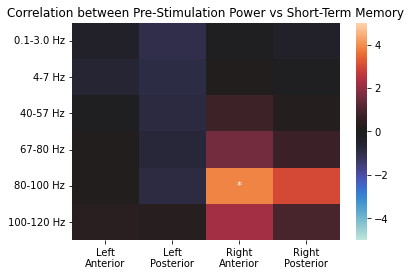

In [ ]:
import importlib
import stats_pipeline
importlib.reload(stats_pipeline)
from stats_pipeline import make_heatmap_linreg
make_heatmap_linreg(power_mem_trial, '$FREQ_log_pre', 'Memory_Score', freqs, xlabel='Correlation between Pre-Stimulation Power', ylabel='Short-Term Memory')

In [ ]:
make_heatmap_linreg(power_mem_3, '$FREQ_pre', 'Prev_Trio')

TypeError: make_heatmap_linreg() missing 1 required positional argument: 'freqs'

LHip3 - LHip4 Delta: r = -0.39064309893986116, p = 0.0024314512384983073
LHip3 - LHip4 Theta: r = -0.3056986828671483, p = 0.019615657864866392
RHip1 - RHip2 Beta: r = 0.37540342443757013, p = 0.003686996134250997
RHip1 - RHip2 GammaLow: r = 0.5664597351120849, p = 3.5698653636645627e-06
RHip1 - RHip2 GammaMed: r = 0.4847599178512427, p = 0.00011516003002627852
RHip1 - RHip2 GammaHigh: r = 0.3700684091641101, p = 0.004246083854678798
RHip3 - RHip4 Beta: r = 0.30455890217249654, p = 0.03336110238858576
RHip3 - RHip4 GammaLow: r = 0.4552785840601869, p = 0.001012782972501829


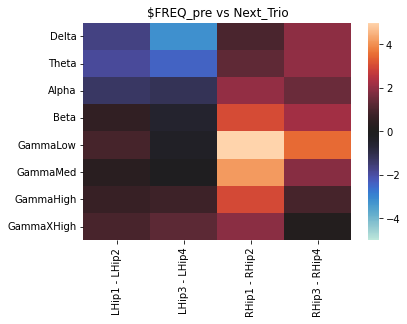

In [ ]:
make_heatmap(power_mem_3, '$FREQ_pre', 'Next_Trio')

In [ ]:
from scipy.stats import linregress

def calc_stats_linreg(df, x, y, freqs, xlabel=None, ylabel=None):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y
    t_arr = np.ndarray(shape=(len(hip_chans), len(freqs)))
    pvals = pd.DataFrame()
    rvals = pd.DataFrame()
    for i, chan in enumerate(hip_chans):
        power_for_chan = df[df['Channel'] == chan]
        for j, freq in enumerate(freqs):
            # if 'log_chg' in x:
            results = linregress(power_for_chan[x.replace('$FREQ', freq)], power_for_chan[y])
            # else:
                # results = linregress(np.log10(power_for_chan[x.replace('$FREQ', freq)]), power_for_chan[y])
            t_arr[i][j] = results.slope / results.stderr
            pvals.loc[chan, freq] = results.pvalue
            rvals.loc[chan, freq] = results.rvalue

    return rvals, pvals

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_trial, '$FREQ_log_pre', 'Memory_Score', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals.loc['RHip1 - RHip2', 'GammaMed']
fdr_bh(pvals)

0.7886304209812275


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.918498  0.918498  0.918498  0.918498  0.918498  0.918498   
LHip3 - LHip4  0.918498  0.918498  0.918498  0.918498  0.918498  0.918498   
RHip1 - RHip2  0.918498  0.918498  0.918498  0.703219  0.023037  0.003222   
RHip3 - RHip4  0.918498  0.918498  0.918498  0.918498  0.106802  0.106802   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.918498    0.918498  
LHip3 - LHip4   0.918498    0.918498  
RHip1 - RHip2   0.268971    0.918498  
RHip3 - RHip4   0.918498    0.918498

In [ ]:
rvals

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2 -0.098956 -0.157925 -0.046598  0.031576  0.041213  0.082263   
LHip3 - LHip4 -0.245104 -0.223865 -0.207231 -0.182384 -0.213039  0.089455   
RHip1 - RHip2 -0.044637  0.030235  0.189951  0.368982  0.692708  0.788630   
RHip3 - RHip4 -0.110626 -0.028925  0.059718  0.192667  0.638875  0.621698   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   0.079792    0.142276  
LHip3 - LHip4   0.067329    0.054284  
RHip1 - RHip2   0.483590    0.308755  
RHip3 - RHip4   0.260736    0.036404

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_3, '$FREQ_log_pre', 'Next_Trio', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaLow'], rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals


0.5632056131590767 0.42943932439275695


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2  0.537894  0.508779  0.945108  0.458143  0.856855  0.785165   
LHip3 - LHip4  0.096239  0.416740  0.529460  0.795346  0.861591  0.868834   
RHip1 - RHip2  0.724781  0.643441  0.235413  0.095622  0.007850  0.052043   
RHip3 - RHip4  0.305382  0.217278  0.393220  0.236498  0.142360  0.294599   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   0.490665    0.451184  
LHip3 - LHip4   0.690968    0.360382  
RHip1 - RHip2   0.099127    0.342258  
RHip3 - RHip4   0.594841    0.823930

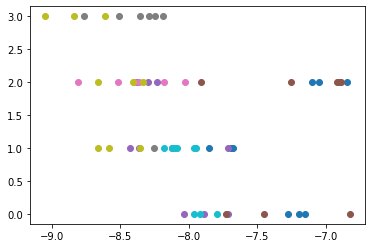

In [ ]:
for pt_num in power_mem_3['ID'].unique():
    power_for_chan = power_mem_3[(power_mem_3['Channel'] == 'LHip3 - LHip4') & (power_mem_3['ID'] == pt_num)]
    plt.scatter(np.log10(power_for_chan['Delta_pre']), power_for_chan['Next_Trio'])

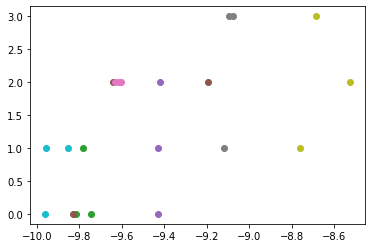

In [ ]:
for pt_num in power_mem_3['ID'].unique():
    power_for_chan = power_mem_3[(power_mem_3['Channel'] == 'RHip1 - RHip2') & (power_mem_3['ID'] == pt_num)]
    plt.scatter(power_for_chan['GammaLow_pre'], power_for_chan['Next_Trio'])

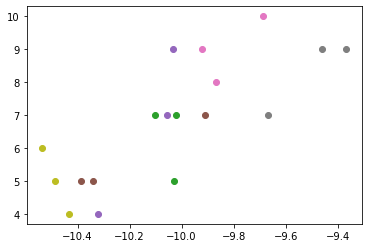

In [ ]:
for pt_num in power_mem_trial['ID'].unique():
    power_for_chan = power_mem_trial[(power_mem_trial['Channel'] == 'RHip1 - RHip2') & (power_mem_trial['ID'] == pt_num)]
    plt.scatter(power_for_chan['GammaMed_pre'], power_for_chan['Memory_Score'])

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_linreg(power_mem_trial, '$FREQ_post', 'Memory_Score', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals

0.5348268877420973


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2  0.278850  0.414895  0.587179  0.902065  0.876203  0.914638   
LHip3 - LHip4  0.043144  0.024828  0.135704  0.216077  0.324543  0.733636   
RHip1 - RHip2  0.550011  0.466391  0.480347  0.241184  0.060112  0.022203   
RHip3 - RHip4  0.745614  0.738096  0.843896  0.806851  0.233665  0.334681   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   0.731103    0.985048  
LHip3 - LHip4   0.863463    0.959232  
RHip1 - RHip2   0.086417    0.201186  
RHip3 - RHip4   0.492996    0.850825

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_mixed(power_mem_trial, '$FREQ_pre', 'Memory_Score', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
fdr_bh(pvals)

4.480872246277664


Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
LHip3 - LHip4  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
RHip1 - RHip2  0.909684  0.909684  0.909684  0.909684  0.003835  0.000241   
RHip3 - RHip4  0.909684  0.909684  0.909684  0.909684  0.197317  0.088857   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.909684    0.909684  
LHip3 - LHip4   0.909684    0.909684  
RHip1 - RHip2   0.682873    0.909684  
RHip3 - RHip4   0.909684    0.909684

In [ ]:
from stats_pipeline import fdr_bh
rvals, pvals = calc_stats_mixed(power_mem_3, '$FREQ_log_pre', 'Next_Trio', freqs)
print(rvals.loc['RHip1 - RHip2', 'GammaMed'])
pvals

NameError: name 'calc_stats_mixed' is not defined

In [ ]:
import statsmodels.formula.api as smf
def calc_stats_mixed(df, x, y, freqs, xlabel=None, ylabel=None):
    if xlabel is None:
        xlabel = x
    if ylabel is None:
        ylabel = y

    tvals = pd.DataFrame()
    coeffs = pd.DataFrame()
    pvals = pd.DataFrame()
    for i, chan in enumerate(hip_chans):
        power_for_chan = df[df['Channel'] == chan]

        formula = y + " ~ "
        for j, freq in enumerate(freqs):
            var = x.replace('$FREQ', freq) # if 'log_chg' in x else "np.log10("+x.replace('$FREQ', freq)+")"
            formula = y + " ~ " + var
            model = smf.mixedlm(formula, power_for_chan, groups=power_for_chan['ID'])
            result = model.fit()
            tvals.loc[chan, freq] = result.tvalues[1]
            coeffs.loc[chan, freq] = result.params[1]
            pvals.loc[chan, freq] = result.pvalues[1]

    return coeffs, pvals

In [ ]:
from stats_pipeline import fdr_bh
coeffs, pvals = calc_stats_mixed(power_mem_trial, '$FREQ_log_pre', 'Memory_Score', freqs)
fdr_bh(pvals)

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
LHip3 - LHip4  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
RHip1 - RHip2  0.909684  0.909684  0.909684  0.909684  0.003835  0.000241   
RHip3 - RHip4  0.909684  0.909684  0.909684  0.909684  0.197317  0.088857   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.909684    0.909684  
LHip3 - LHip4   0.909684    0.909684  
RHip1 - RHip2   0.682873    0.909684  
RHip3 - RHip4   0.909684    0.909684

In [ ]:
coeffs, pvals = calc_stats_mixed(power_mem_trial, '$FREQ_pre', 'Memory_Score', freqs)
fdr_bh(pvals)

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
Channel                                                                     
LHip1 - LHip2  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
LHip3 - LHip4  0.909684  0.909684  0.909684  0.909684  0.909684  0.909684   
RHip1 - RHip2  0.909684  0.909684  0.909684  0.909684  0.003835  0.000241   
RHip3 - RHip4  0.909684  0.909684  0.909684  0.909684  0.197317  0.088857   

               GammaHigh  GammaXHigh  
Channel                               
LHip1 - LHip2   0.909684    0.909684  
LHip3 - LHip4   0.909684    0.909684  
RHip1 - RHip2   0.682873    0.909684  
RHip3 - RHip4   0.909684    0.909684

In [ ]:
coeffs

Delta     Theta     Alpha      Beta  GammaLow  GammaMed  \
LHip1 - LHip2  0.669728  0.566166  1.409796  1.104666  0.487972  0.556345   
LHip3 - LHip4  0.283729  0.173781  0.437125  0.223755 -0.623266  2.052141   
RHip1 - RHip2 -0.326537 -0.107857  0.456702  1.054338  2.875792  4.480872   
RHip3 - RHip4 -0.627036  0.125916  0.585192  1.011870  5.120010  4.455226   

               GammaHigh  GammaXHigh  
LHip1 - LHip2   1.836365    2.300369  
LHip3 - LHip4   0.318720    0.471239  
RHip1 - RHip2   2.320659    1.833772  
RHip3 - RHip4   0.545522    0.248383

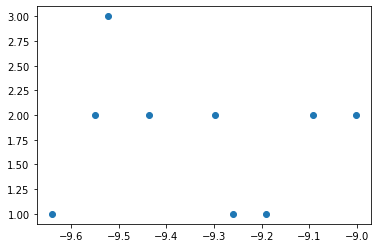

In [ ]:
#for pt_num in power_mem_3['ID'].unique():
pt_num = 113
power_for_chan = power_mem_3[(power_mem_3['Channel'] == 'RHip1 - RHip2') & (power_mem_3['ID'] == pt_num)]
plt.scatter(np.log10(power_for_chan['GammaMed_pre']), power_for_chan['Next_Trio'])

## Change in Power

In [ ]:
make_heatmap(power_mem_trial, '$FREQ_log_chg', 'Memory_Score')

NameError: name 'make_heatmap' is not defined

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
freq_labels = list(map(lambda freq: freq[len('Gamma'):]+'\nGamma' if freq.startswith('Gamma') else freq, freqs))
for i, chan in enumerate(hip_chans):
    ax = axs[i // 2, i % 2]
    power_for_chan = power_log_chg[power_log_chg['Channel'] == chan]
    ax.violinplot([power_for_chan[freq + '_log_chg'] for freq in freqs])
    ax.set_xticks(range(1,9), freq_labels)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Change in Power After Stim (dB)')
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title(chan)

In [ ]:
make_heatmap(power_mem_3, '$FREQ_log_chg', 'Prev_Trio')

RHip1 - RHip2 Delta: r = -0.3017461591941914, p = 0.021338183133688172
RHip1 - RHip2 Alpha: r = -0.2634716568270824, p = 0.04568181763759358
RHip1 - RHip2 Beta: r = -0.2819132045010935, p = 0.03203743576492514
RHip3 - RHip4 Delta: r = -0.3514177953218534, p = 0.013288071435225991


In [ ]:
make_heatmap(power_mem_3, '$FREQ_log_chg', 'Next_Trio')

## POST-Stim Power

LHip3 - LHip4 Delta: r = -0.48131860083754907, p = 0.04314368915195751
LHip3 - LHip4 Theta: r = -0.5263739038153527, p = 0.024828144035354254
RHip1 - RHip2 GammaMed: r = 0.5348268877420973, p = 0.022202996645914023


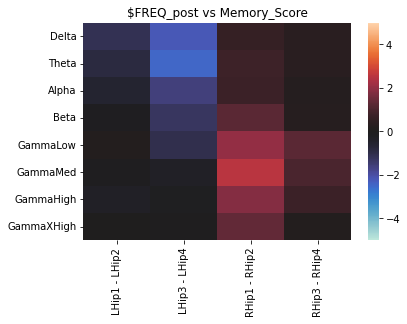

In [ ]:
make_heatmap(power_mem_trial, '$FREQ_post', 'Memory_Score')

In [ ]:
make_heatmap(power_mem_3, '$FREQ_post', 'Prev_Trio')

LHip3 - LHip4 Delta: r = -0.3387639985061827, p = 0.00928997120962828
LHip3 - LHip4 Theta: r = -0.32489385211489613, p = 0.012833190350609515
LHip3 - LHip4 Alpha: r = -0.3286685577546354, p = 0.01176939173565161
LHip3 - LHip4 Beta: r = -0.3486142143207956, p = 0.00732113750976252
LHip3 - LHip4 GammaLow: r = -0.26142037304391186, p = 0.04745728494689235


LHip1 - LHip2 Delta: r = -0.38242087856997986, p = 0.0030511845495161346
LHip1 - LHip2 Theta: r = -0.32821092931222706, p = 0.011894168706362005
LHip3 - LHip4 Theta: r = -0.3275406310032418, p = 0.01207899124962671
RHip1 - RHip2 Beta: r = 0.32201438907705826, p = 0.013699391351325429
RHip1 - RHip2 GammaLow: r = 0.5445235926291967, p = 9.92886851431459e-06
RHip1 - RHip2 GammaMed: r = 0.47221889806397266, p = 0.00018222516678847962
RHip1 - RHip2 GammaHigh: r = 0.31598079865851586, p = 0.01567848516823266
RHip3 - RHip4 Delta: r = 0.31641824622991754, p = 0.026759869400008858
RHip3 - RHip4 Theta: r = 0.32706350953516977, p = 0.021800372232496614
RHip3 - RHip4 GammaLow: r = 0.4458539084293326, p = 0.0013243406141533168
RHip3 - RHip4 GammaMed: r = 0.2901668116812999, p = 0.04312721831429723


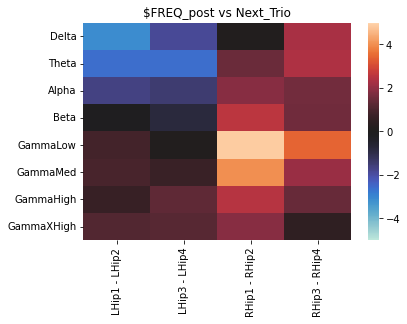

In [ ]:
make_heatmap(power_mem_3, '$FREQ_post', 'Next_Trio')

messing around

(array([ 4., 50., 71., 93., 99., 71., 37., 26., 12.,  5.]),
 array([-9.60204614, -9.22639958, -8.85075302, -8.47510647, -8.09945991,
        -7.72381335, -7.3481668 , -6.97252024, -6.59687368, -6.22122713,
        -5.84558057]),
 <BarContainer object of 10 artists>)

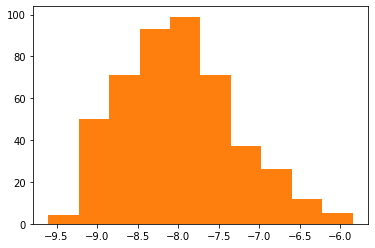

In [ ]:
fig, ax = plt.subplots()

ax.hist(np.log10(power_log_chg['Theta_post']))

plc = pd.read_csv('pre_post_stim.csv')
ax.hist(np.log10(plc['Theta_post']))

In [ ]:
hand_calc = power_log_chg.copy()
stored = plc.copy()
stored['Stim_Num'] += 1

In [ ]:
pd.concat([hand_calc, stored]).drop_duplicates(['ID', 'Trial', 'Channel', 'Stim_Num'], keep=False)

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0    100      1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1    100      1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
2    100      1  LatT1 - LatT2  1.378031e-09  2.185936e-09  1.179630e-09   
3    100      1  LatT3 - LatT4  8.129781e-08  7.790410e-09  4.389105e-09   
16   100      2  LHip1 - LHip2  6.111540e-08  3.771269e-08  2.708512e-08   
..   ...    ...            ...           ...           ...           ...   
459  202      2    LHT3 - LHT4  1.518380e-08  2.126930e-09  3.240071e-09   
464  202      3    LOT1 - LOT2  3.550790e-08  1.153714e-08  2.278720e-09   
465  202      3    LOT3 - LOT4  9.146609e-09  6.811802e-09  3.374165e-09   
466  202      3    LHT1 - LHT2  1.318418e-09  1.206045e-09  9.419762e-10   
467  202      3    LHT3 - LHT4  1.042007e-08  8.687519e-10  1.712772e-09   

        Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0    1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1    3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
2    2.098490e-10    1.228712e-11   4.416371e-11   1.970511e-11  ...   
3    1.734181e-09    3.738994e-11   2.994732e-10   5.937977e-11  ...   
16   1.352690e-08    9.112087e-11   7.153666e-10   2.447149e-10  ...   
..            ...             ...            ...            ...  ...   
459  5.832078e-10    1.252654e-11   3.258594e-11   1.048236e-11  ...   
464  2.943730e-09    2.888773e-11   3.305943e-10   1.487729e-10  ...   
465  2.080614e-09    4.543147e-11   1.954827e-10   4.527764e-11  ...   
466  6.011702e-10    1.193692e-11   6.070554e-11   2.430652e-11  ...   
467  5.998392e-10    1.263479e-11   4.582474e-11   1.437073e-11  ...   

     GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  \
0    2.448737e-10    3.160809e-11       0.172679      -0.046258   
1    8.771663e-11    2.150510e-11       0.697190       0.141332   
2    1.546049e-11    7.259526e-12      -0.110548       0.050514   
3    4.948296e-11    2.017395e-11       0.883454      -0.306906   
16   2.789658e-10    3.096874e-11      -0.058003      -0.223956   
..            ...             ...            ...            ...   
459  1.385542e-11    6.421238e-12       0.630400       0.462898   
464  6.489303e-11    1.398333e-11       0.362258      -0.006381   
465  7.123105e-11    9.480527e-12       0.065842       0.045289   
466  2.610208e-11    8.207254e-12      -0.117596      -0.105110   
467  1.963331e-11    6.364368e-12       0.564010      -0.530514   

     Alpha_log_chg  Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  \
0        -0.186435     -0.062647         -0.010354          0.110085   
1        -0.126444     -0.027167         -0.000208          0.235129   
2         0.177617     -0.067019         -0.056950          0.105356   
3        -0.310061      0.078600          0.134880          0.079183   
16       -0.033788     -0.045275         -0.172873         -0.056891   
..             ...           ...               ...               ...   
459       0.234890     -0.069142         -0.149169         -0.121160   
464      -0.222434      0.229174          0.100273          0.360326   
465       0.021033      0.059923         -0.012712         -0.196786   
466       0.172754     -0.064298         -0.152160         -0.030952   
467       0.166849      0.232527          0.016653         -0.135515   

     GammaHigh_log_chg  GammaXHigh_log_chg  
0            -0.134723            0.111894  
1             0.192664            0.121860  
2             0.030603            0.082202  
3             0.190453            0.049423  
16           -0.163039            0.040121  
..                 ...                 ...  
459           0.230389            0.089655  
464           0.100764           -0.153230  
465           0.191675           -0.154657  
466          -0.088260           -0.057565  
467           0.078629            0.091936  

[280 rows x 28 co

In [ ]:
merged = hand_calc.merge(stored, on=['ID', 'Trial', 'Channel', 'Stim_Num'], indicator=True, how='outer')

In [ ]:
merged['_merge'].value_counts()

both          328
left_only     140
right_only    140
Name: _merge, dtype: int64

In [ ]:
merged[merged['_merge'] == 'left_only'][['ID', 'Trial', 'Channel', 'Stim_Num', 'Delta_post_x']]

ID  Trial        Channel  Stim_Num  Delta_post_x
0    100      1  LHip1 - LHip2         0  1.142425e-07
1    100      1  LHip3 - LHip4         0  3.784396e-07
2    100      1  LatT1 - LatT2         0  1.378031e-09
3    100      1  LatT3 - LatT4         0  8.129781e-08
16   100      2  LHip1 - LHip2         0  6.111540e-08
..   ...    ...            ...       ...           ...
451  202      2    LHT3 - LHT4         0  3.282836e-09
460  202      3    LOT1 - LOT2         2  3.962035e-09
461  202      3    LOT3 - LOT4         2  6.539377e-09
462  202      3    LHT1 - LHT2         2  1.572392e-09
463  202      3    LHT3 - LHT4         2  1.140535e-08

[140 rows x 5 columns]

In [ ]:
merged[merged['_merge'] == 'right_only'][['ID', 'Trial', 'Channel', 'Stim_Num', 'Delta_post_x']]

ID  Trial        Channel  Stim_Num  Delta_post_x
468  100      1  LHip1 - LHip2         4           NaN
469  100      1  LHip3 - LHip4         4           NaN
470  100      1  LatT1 - LatT2         4           NaN
471  100      1  LatT3 - LatT4         4           NaN
472  100      2  LHip1 - LHip2         4           NaN
..   ...    ...            ...       ...           ...
603  202      2    LHT3 - LHT4         3           NaN
604  202      3    LOT1 - LOT2         4           NaN
605  202      3    LOT3 - LOT4         4           NaN
606  202      3    LHT1 - LHT2         4           NaN
607  202      3    LHT3 - LHT4         4           NaN

[140 rows x 5 columns]

In [ ]:
len(plc), len(power_log_chg)

(468, 468)

In [ ]:
power_log_chg.head()

ID  Trial        Channel    Delta_post    Theta_post    Alpha_post  \
0  100      1  LHip1 - LHip2  1.142425e-07  7.161263e-08  2.537439e-08   
1  100      1  LHip3 - LHip4  3.784396e-07  7.526684e-08  5.945997e-09   
2  100      1  LatT1 - LatT2  1.378031e-09  2.185936e-09  1.179630e-09   
3  100      1  LatT3 - LatT4  8.129781e-08  7.790410e-09  4.389105e-09   
4  100      1  LHip1 - LHip2  5.835947e-08  3.228662e-08  2.086371e-08   

      Beta_post  GammaHigh_post  GammaLow_post  GammaMed_post  ...  \
0  1.169223e-08    9.841945e-11   9.902345e-10   3.155199e-10  ...   
1  3.396220e-09    8.039247e-11   8.468632e-10   1.507339e-10  ...   
2  2.098490e-10    1.228712e-11   4.416371e-11   1.970511e-11  ...   
3  1.734181e-09    3.738994e-11   2.994732e-10   5.937977e-11  ...   
4  8.328850e-09    1.467862e-10   1.225056e-09   2.848021e-10  ...   

   GammaMed_pre  GammaXHigh_pre  Delta_log_chg  Theta_log_chg  Alpha_log_chg  \
0  2.448737e-10    3.160809e-11       0.172679      -0.046258      -0.186435   
1  8.771663e-11    2.150510e-11       0.697190       0.141332      -0.126444   
2  1.546049e-11    7.259526e-12      -0.110548       0.050514       0.177617   
3  4.948296e-11    2.017395e-11       0.883454      -0.306906      -0.310061   
4  5.778968e-10    4.162106e-11       0.439985       0.037215      -0.182963   

   Beta_log_chg  GammaLow_log_chg  GammaMed_log_chg  GammaHigh_log_chg  \
0     -0.062647         -0.010354          0.110085          -0.134723   
1     -0.027167         -0.000208          0.235129           0.192664   
2     -0.067019         -0.056950          0.105356           0.030603   
3      0.078600          0.134880          0.079183           0.190453   
4      0.020740         -0.115489         -0.307307           0.136379   

   GammaXHigh_log_chg  
0            0.111894  
1            0.121860  
2            0.082202  
3            0.049423  
4           -0.060573  

[5 rows x 28 columns]

# Omnibus OLS

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

tvals_grid = np.ndarray((3, 4, 3))
pvals_grid = np.ndarray((3, 4, 3))
for i, x in enumerate(['pre', 'chg', 'post']):
    for j, chan in enumerate(hip_chans):
        df_filtered = power_mem_trial[power_mem_trial['Channel'] == chan]
        formula = f"Memory_Score ~ Theta_log_{x} + GammaLow_log_{x} + GammaHigh_log_{x}"
        model = smf.ols(formula, df_filtered)
        results = model.fit()
        if i == 1:
            print(chan +":")
            display(results.summary())
        tvals_grid[i][j] = results.tvalues['Theta_log_'+x:'GammaHigh_log_'+x]
        pvals_grid[i][j] = results.pvalues['Theta_log_'+x:'GammaHigh_log_'+x]

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                 -0.042
Method:                 Least Squares   F-statistic:                    0.7706
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.529
Time:                        09:01:30   Log-Likelihood:                -35.859
No. Observations:                  18   AIC:                             79.72
Df Residuals:                      14   BIC:                             83.28
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9063      0.532     12.986      0.000       5.766       8.047
Theta_log_chg         1.6176      1.775      0.911      0.377      -2.189       5.424
GammaLow_log_chg      2.2242      4.224      0.527      0.607      -6.834      11.283
GammaHigh_log_chg    -5.3167      3.499     -1.520      0.151     -12.821       2.188
==============================================================================
Omnibus:                        0.351   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.498
Skew:                           0.156   Prob(JB):                        0.780
Kurtosis:                       2.248   Cond. No.                         9.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     2.275
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.125
Time:                        09:01:30   Log-Likelihood:                -33.660
No. Observations:                  18   AIC:                             75.32
Df Residuals:                      14   BIC:                             78.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.9330      0.438     15.835      0.000       5.994       7.872
Theta_log_chg        -1.7134      1.499     -1.143      0.272      -4.928       1.501
GammaLow_log_chg      3.4592      2.495      1.387      0.187      -1.891       8.810
GammaHigh_log_chg    -8.7532      6.098     -1.435      0.173     -21.832       4.325
==============================================================================
Omnibus:                        0.319   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.853   Jarque-Bera (JB):                0.294
Skew:                          -0.253   Prob(JB):                        0.863
Kurtosis:                       2.630   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     2.958
Date:                Fri, 23 Dec 2022   Prob (F-statistic):             0.0687
Time:                        09:01:30   Log-Likelihood:                -32.033
No. Observations:                  18   AIC:                             72.07
Df Residuals:                      14   BIC:                             75.63
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.4687      0.439     14.732      0.000       5.527       7.410
Theta_log_chg         1.2623      0.909      1.388      0.187      -0.688       3.212
GammaLow_log_chg     -5.4351      2.014     -2.699      0.017      -9.754      -1.116
GammaHigh_log_chg     4.2595      2.313      1.841      0.087      -0.702       9.221
==============================================================================
Omnibus:                        0.397   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.820   Jarque-Bera (JB):                0.528
Skew:                           0.199   Prob(JB):                        0.768
Kurtosis:                       2.261   Cond. No.                         7.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


RHip3 - RHip4:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     2.549
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.109
Time:                        09:01:31   Log-Likelihood:                -26.008
No. Observations:                  15   AIC:                             60.02
Df Residuals:                      11   BIC:                             62.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.5702      0.496     13.240      0.000       5.478       7.662
Theta_log_chg         2.8243      1.319      2.141      0.056      -0.079       5.728
GammaLow_log_chg     -1.4739      2.745     -0.537      0.602      -7.516       4.568
GammaHigh_log_chg    -8.4650      3.508     -2.413      0.034     -16.186      -0.744
==============================================================================
Omnibus:                        1.094   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.751
Skew:                          -0.116   Prob(JB):                        0.687
Kurtosis:                       1.928   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
pvals_after = np.apply_along_axis(lambda x: fdrcorrection(x)[1], axis=0, arr=pvals_grid)
np.where(pvals_after < 0.05)

(array([0, 0, 1], dtype=int64),
 array([2, 3, 2], dtype=int64),
 array([1, 1, 1], dtype=int64))

In [ ]:
pvals_after

array([[[0.37747775, 0.74204461, 0.55048311],
        [0.4015474 , 0.28086143, 0.13696996],
        [0.20289644, 0.03822376, 0.75481697],
        [0.09947097, 0.03792471, 0.73967004]],

       [[0.37747775, 0.74204461, 0.45263355],
        [0.4015474 , 0.28086143, 0.17311913],
        [0.2800804 , 0.03822376, 0.26051664],
        [0.09947097, 0.6020139 , 0.10329409]],

       [[0.37747775, 0.62648971, 0.55048311],
        [0.08145279, 0.33962522, 0.13696996],
        [0.61387729, 0.82639237, 0.64310153],
        [0.13141866, 0.13715876, 0.83372556]]])

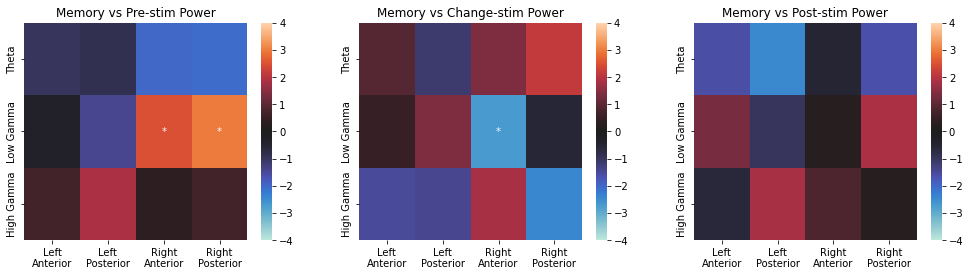

In [ ]:
import seaborn as sns

xs = ['Pre', 'Change', 'Post']
fig, axs = plt.subplots(1,3)
fig.set_size_inches(17,4)
for i in range(3):
    sns.heatmap(tvals_grid[i].T, 
        xticklabels=['Left\nAnterior', 'Left\nPosterior', 'Right\nAnterior', 'Right\nPosterior'],
        yticklabels=['Theta', 'Low Gamma', 'High Gamma'],
        center=0,
        vmax=4, vmin=-4,
        annot=np.where(pvals_after[i].T < 0.05, '*', ''),
        fmt='',
        ax=axs[i])
    axs[i].set_title(f'Memory vs {xs[i]}-stim Power')

Text(0, 0.5, 'Immediate Recall')

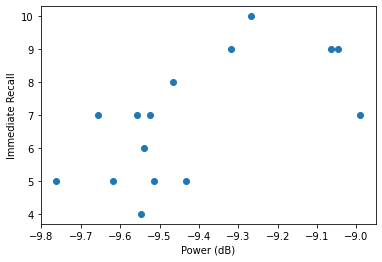

In [ ]:
df_filtered = power_mem_trial[power_mem_trial['Channel'] == 'RHip3 - RHip4']
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
# plt.scatter(df_filtered['GammaLow_log_pre'], df_filtered['Memory_Score'])
plt.scatter(df_filtered['GammaLow_log_pre'], df_filtered['Memory_Score'])
plt.xlabel('Power (dB)')
plt.ylabel('Immediate Recall')
# plt.legend(['pre', 'post'])
# plt.scatter(df_filtered['pre_pac'], df_filtered['Memory_Score'])

In [ ]:
from scipy.stats import linregress
linregress(df_filtered['GammaLow_log_pre'], df_filtered['Memory_Score'])

LinregressResult(slope=5.038369123213976, intercept=54.33070952504346, rvalue=0.6388748889752464, pvalue=0.010353054438506521, stderr=1.6826904573806647, intercept_stderr=15.856383331860087)

In [ ]:
scipy.__version__

'1.7.3'

TODO

LinregressResult(slope=2.8864681678685487, intercept=34.02273774798073, rvalue=0.6927075257974956, pvalue=0.0014397869735771997, stderr=0.751318010450873, intercept_stderr=7.0848383080127215)
LinregressResult(slope=-2.214218478538787, intercept=6.967388850105738, rvalue=-0.3170320617355714, pvalue=0.19988958716070562, stderr=1.6559820554718956, intercept_stderr=0.4461022413853189)
LinregressResult(slope=-0.14071297762487134, intercept=-1.264918331481672, rvalue=-0.23584928965747612, pvalue=0.3461040672619492, stderr=0.14494787609762647, intercept_stderr=1.366841006014582)


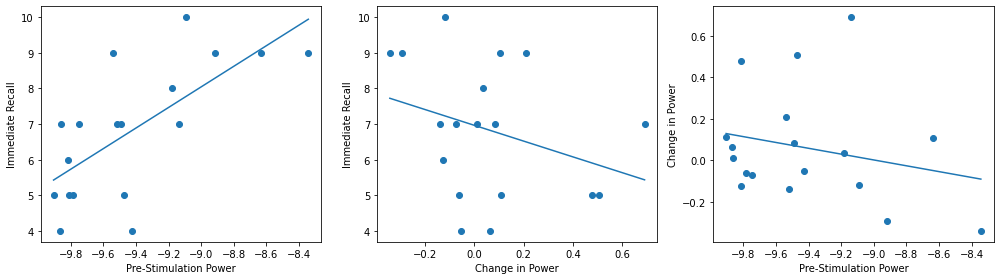

In [ ]:
from scipy.stats import linregress

fig, axs = plt.subplots(1,3)
fig.set_size_inches(14, 4)
# colors = ['red', 'orange', 'tab:olive', 'green', 'blue', 'violet', 'pink', 'brown', 'gray', 'steelblue', 'lightcoral', 'mediumaquamarine']
axs[0].scatter(df_filtered['GammaLow_log_pre'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['GammaLow_log_pre'].min(), df_filtered['GammaLow_log_pre'].max()])
results = linregress(df_filtered['GammaLow_log_pre'], df_filtered['Memory_Score'])
print(results)
axs[0].plot(xs, results.intercept + results.slope * xs)
axs[0].set_xlabel('Pre-Stimulation Power')
axs[0].set_ylabel('Immediate Recall')

axs[1].scatter(df_filtered['GammaLow_log_chg'], df_filtered['Memory_Score'])
xs = np.array([df_filtered['GammaLow_log_chg'].min(), df_filtered['GammaLow_log_chg'].max()])
results = linregress(df_filtered['GammaLow_log_chg'], df_filtered['Memory_Score'])
print(results)
axs[1].plot(xs, results.intercept + results.slope * xs)
axs[1].set_xlabel('Change in Power')
axs[1].set_ylabel('Immediate Recall')

axs[2].scatter(df_filtered['GammaLow_log_pre'], df_filtered['GammaLow_log_chg'])
xs = np.array([df_filtered['GammaLow_log_pre'].min(), df_filtered['GammaLow_log_pre'].max()])
results = linregress(df_filtered['GammaLow_log_pre'], df_filtered['GammaLow_log_chg'])
print(results)
axs[2].plot(xs, results.intercept + results.slope * xs)
axs[2].set_xlabel('Pre-Stimulation Power')
axs[2].set_ylabel('Change in Power')
fig.tight_layout()

In [ ]:
df_filtered['ID'].unique()

array([105, 109, 110, 112, 113, 115], dtype=int64)

In [ ]:
formula = f"Memory_Score ~ GammaLow_log_pre + GammaLow_log_chg"
model = smf.ols(formula, df_filtered)
results = model.fit()
display(results.summary())

NameError: name 'smf' is not defined

In [ ]:
formula = f"Memory_Score ~ GammaLow_log_pre"
model = smf.ols(formula, df_filtered)
results = model.fit()
display(results.summary())

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     14.76
Date:                Wed, 07 Dec 2022   Prob (F-statistic):            0.00144
Time:                        07:31:10   Log-Likelihood:                -30.569
No. Observations:                  18   AIC:                             65.14
Df Residuals:                      16   BIC:                             66.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           34.0227      7.085      4.802      0.000      19.004      49.042
GammaLow_log_pre     2.8865      0.751      3.842      0.001       1.294       4.479
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.068
Skew:                          -0.019   Prob(JB):                        0.966
Kurtosis:                       2.701   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df_filtered = power_mem_trial[power_mem_trial['Channel'] == 'RHip1 - RHip2']
formula = f"Memory_Score ~ GammaHigh_log_pre + GammaHigh_log_chg"
model = smf.ols(formula, df_filtered)
results = model.fit()
display(results.summary())

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     6.495
Date:                Wed, 07 Dec 2022   Prob (F-statistic):            0.00929
Time:                        07:36:09   Log-Likelihood:                -30.837
No. Observations:                  18   AIC:                             67.67
Df Residuals:                      15   BIC:                             70.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            47.5076     11.473      4.141      0.001      23.054      71.961
GammaHigh_log_pre     3.9935      1.123      3.556      0.003       1.600       6.387
GammaHigh_log_chg    -0.6075      1.551     -0.392      0.701      -3.913       2.698
==============================================================================
Omnibus:                        0.570   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.752   Jarque-Bera (JB):                0.623
Skew:                           0.332   Prob(JB):                        0.732
Kurtosis:                       2.376   Cond. No.                         340.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
linregress(df_filtered['GammaLow_log_chg'], df_filtered['Memory_Score'])

LinregressResult(slope=-2.214218478538787, intercept=6.967388850105738, rvalue=-0.3170320617355714, pvalue=0.19988958716070562, stderr=1.6559820554718956, intercept_stderr=0.4461022413853189)

In [ ]:
%matplotlib qt5

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = np.outer(np.linspace(-0.4, 0.6, 10), np.ones(10))
y = np.outer(np.linspace(-0.3, 1.6, 10), np.ones(10)).T
z = ys[0] + ys[2]*x + ys[1]*y
ax.scatter(df_filtered['GammaLow_log_chg'], df_filtered['Theta_log_chg'], df_filtered['Memory_Score'])
ax.plot_surface(x, y, z)

eval_env: 1


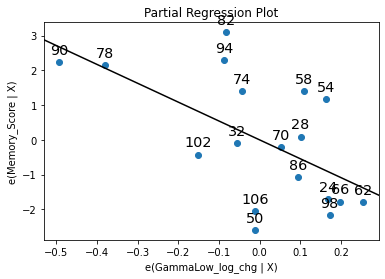

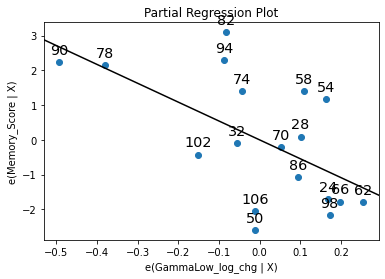

In [ ]:
from statsmodels.graphics.regressionplots import plot_partregress

plot_partregress("Memory_Score", "GammaLow_log_chg", ["Theta_log_chg", "GammaHigh_log_chg"], data=df_filtered)

In [ ]:
formula = f"Memory_Score ~ Theta_log_chg + GammaLow_log_chg + GammaHigh_log_chg"
model = smf.ols(formula, df_filtered)
results = model.fit()
results.summary()

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     2.549
Date:                Tue, 29 Nov 2022   Prob (F-statistic):              0.109
Time:                        21:51:25   Log-Likelihood:                -26.008
No. Observations:                  15   AIC:                             60.02
Df Residuals:                      11   BIC:                             62.85
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             6.5702      0.496     13.240      0.000       5.478       7.662
Theta_log_chg         2.8243      1.319      2.141      0.056      -0.079       5.728
GammaLow_log_chg     -1.4739      2.745     -0.537      0.602      -7.516       4.568
GammaHigh_log_chg    -8.4650      3.508     -2.413      0.034     -16.186      -0.744
==============================================================================
Omnibus:                        1.094   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.579   Jarque-Bera (JB):                0.751
Skew:                          -0.116   Prob(JB):                        0.687
Kurtosis:                       1.928   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

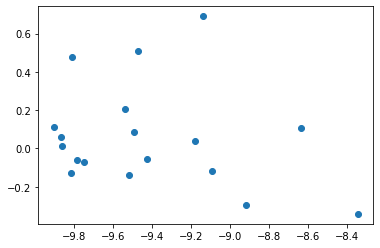

In [ ]:
plt.scatter(df_filtered['GammaLow_log_pre'], df_filtered['GammaLow_log_chg'])

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    print(chan +":")
    df_filtered = power_mem_trial[power_mem_trial['Channel'] == chan]
    formula = "Memory_Score ~ "
    for freq in freqs:
        formula += f" + {freq}_log_pre"
    model = smf.ols(formula, df_filtered)
    results = model.fit()
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.8919
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.533
Time:                        09:49:25   Log-Likelihood:                -33.667
No. Observations:                  18   AIC:                             81.33
Df Residuals:                      11   BIC:                             87.57
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.8440     20.742      0.185      0.856     -41.809      49.497
Delta_log_pre         7.4164      4.038      1.837      0.093      -1.470      16.303
Theta_log_pre       -12.6519      5.763     -2.195      0.050     -25.336       0.032
Alpha_log_pre         5.7860      3.758      1.540      0.152      -2.484      14.056
Beta_log_pre          1.4394      2.874      0.501      0.626      -4.887       7.766
GammaLow_log_pre     -7.1918      4.755     -1.513      0.159     -17.657       3.273
GammaHigh_log_pre     4.5553      3.238      1.407      0.187      -2.571      11.681
==============================================================================
Omnibus:                        2.391   Durbin-Watson:                   1.289
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.664
Skew:                           0.733   Prob(JB):                        0.435
Kurtosis:                       2.734   Cond. No.                         949.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                 -0.266
Method:                 Least Squares   F-statistic:                    0.4047
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.861
Time:                        09:49:25   Log-Likelihood:                -35.439
No. Observations:                  18   AIC:                             84.88
Df Residuals:                      11   BIC:                             91.11
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.1153     21.453      0.425      0.679     -38.102      56.333
Delta_log_pre         0.7687      4.600      0.167      0.870      -9.355      10.893
Theta_log_pre        -1.6840      5.415     -0.311      0.762     -13.601      10.233
Alpha_log_pre        -1.0946      3.765     -0.291      0.777      -9.381       7.192
Beta_log_pre          1.2978      3.347      0.388      0.706      -6.070       8.665
GammaLow_log_pre     -2.7856      3.388     -0.822      0.428     -10.241       4.670
GammaHigh_log_pre     3.2567      2.796      1.165      0.269      -2.898       9.411
==============================================================================
Omnibus:                        0.635   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.612
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.097   Cond. No.                         900.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     3.806
Date:                Wed, 02 Nov 2022   Prob (F-statistic):             0.0266
Time:                        09:49:25   Log-Likelihood:                -26.339
No. Observations:                  18   AIC:                             66.68
Df Residuals:                      11   BIC:                             72.91
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            21.0136     14.251      1.475      0.168     -10.352      52.380
Delta_log_pre        -1.4823      1.868     -0.793      0.444      -5.595       2.630
Theta_log_pre        -0.3275      2.191     -0.149      0.884      -5.150       4.495
Alpha_log_pre        -0.0343      2.987     -0.011      0.991      -6.609       6.541
Beta_log_pre          1.2860      3.200      0.402      0.695      -5.756       8.328
GammaLow_log_pre      4.2248      1.751      2.413      0.034       0.371       8.078
GammaHigh_log_pre    -2.1654      1.996     -1.085      0.301      -6.558       2.227
==============================================================================
Omnibus:                        0.283   Durbin-Watson:                   2.509
Prob(Omnibus):                  0.868   Jarque-Bera (JB):                0.060
Skew:                           0.122   Prob(JB):                        0.970
Kurtosis:                       2.857   Cond. No.                         976.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip3 - RHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     2.602
Date:                Wed, 02 Nov 2022   Prob (F-statistic):              0.106
Time:                        09:49:25   Log-Likelihood:                -21.848
No. Observations:                  15   AIC:                             57.70
Df Residuals:                       8   BIC:                             62.65
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            45.7544     26.304      1.739      0.120     -14.902     106.411
Delta_log_pre        -2.9107      2.565     -1.135      0.289      -8.824       3.003
Theta_log_pre         1.9962      5.413      0.369      0.722     -10.486      14.479
Alpha_log_pre        -4.5840      3.562     -1.287      0.234     -12.799       3.631
Beta_log_pre          4.6935      4.606      1.019      0.338      -5.928      15.315
GammaLow_log_pre      6.2658      2.487      2.520      0.036       0.531      12.001
GammaHigh_log_pre    -1.5570      2.604     -0.598      0.566      -7.563       4.449
==============================================================================
Omnibus:                        0.186   Durbin-Watson:                   2.537
Prob(Omnibus):                  0.911   Jarque-Bera (JB):                0.299
Skew:                           0.213   Prob(JB):                        0.861
Kurtosis:                       2.455   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
import statsmodels.formula.api as smf

formula = "Memory_Score ~  + GammaLow_log_pre"
model = smf.mixedlm(formula, power_mem_trial, groups=power_mem_trial['ID'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: Memory_Score
No. Observations: 120     Method:             REML        
No. Groups:       10      Scale:              1.6388      
Min. group size:  12      Log-Likelihood:     -214.4191   
Max. group size:  12      Converged:          Yes         
Mean group size:  12.0                                    
----------------------------------------------------------
                  Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept         7.615    3.370 2.260 0.024  1.010 14.220
GammaLow_log_pre  0.064    0.344 0.185 0.853 -0.611  0.738
Group Var         3.020    1.210                          
==========================================================

"""

# Short Omnibus

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

tvals_grid = np.ndarray((3, 4, 3))
pvals_grid = np.ndarray((3, 4, 3))
for i, x in enumerate(['pre', 'chg', 'post']):
    for j, chan in enumerate(hip_chans):
        # print(chan +":")
        df_filtered = power_mem_trial[power_mem_trial['Channel'] == chan]
        formula = f"Memory_Score ~ Theta_log_{x} + GammaLow_log_{x} + GammaHigh_log_{x}"
        model = smf.ols(formula, df_filtered)
        results = model.fit()
        # display(results.summary())
        tvals_grid[i][j] = results.tvalues['Theta_log_'+x:'GammaHigh_log_'+x]
        pvals_grid[i][j] = results.pvalues['Theta_log_'+x:'GammaHigh_log_'+x]

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
pvals_after = np.apply_along_axis(lambda x: fdrcorrection(x)[1], axis=0, arr=pvals_grid)
np.where(pvals_after < 0.05)

(array([0, 0, 1], dtype=int64),
 array([2, 3, 2], dtype=int64),
 array([1, 1, 1], dtype=int64))

In [ ]:
pvals_grid[0]

array([[0.34756004, 0.74204461, 0.49560888],
       [0.4015474 , 0.17981283, 0.08441303],
       [0.06763215, 0.02548251, 0.75481697],
       [0.06631398, 0.01264157, 0.49311336]])

In [ ]:
pvals_grid[0][0]

array([0.34756004, 0.74204461, 0.49560888])

In [ ]:
pvals_after[0]

array([[0.37747775, 0.74204461, 0.55048311],
       [0.4015474 , 0.28086143, 0.13696996],
       [0.20289644, 0.03822376, 0.75481697],
       [0.09947097, 0.03792471, 0.73967004]])

In [ ]:
pvals_after[np.nonzero(pvals_after < 0.05)]

array([0.03822376, 0.03792471, 0.03822376])

In [ ]:
np.argwhere(pvals_after < 0.05)

array([[0, 2, 1],
       [0, 3, 1],
       [1, 2, 1]], dtype=int64)

In [ ]:
tvals_grid[1,2,1]

-2.6992059025456427

In [ ]:
pvals_grid

array([[[0.34756004, 0.74204461, 0.49560888],
        [0.4015474 , 0.17981283, 0.08441303],
        [0.06763215, 0.02548251, 0.75481697],
        [0.06631398, 0.01264157, 0.49311336]],

       [[0.37747775, 0.60669976, 0.15087785],
        [0.27218103, 0.18724096, 0.17311913],
        [0.18672027, 0.01728351, 0.08683888],
        [0.05550425, 0.6020139 , 0.03443136]],

       [[0.1323819 , 0.2088299 , 0.55048311],
        [0.02715093, 0.33962522, 0.09131331],
        [0.61387729, 0.82639237, 0.42873436],
        [0.13141866, 0.09143917, 0.83372556]]])

In [ ]:
pvals_after

array([[[0.37747775, 0.74204461, 0.55048311],
        [0.4015474 , 0.28086143, 0.13696996],
        [0.20289644, 0.03822376, 0.75481697],
        [0.09947097, 0.03792471, 0.73967004]],

       [[0.37747775, 0.74204461, 0.45263355],
        [0.4015474 , 0.28086143, 0.17311913],
        [0.2800804 , 0.03822376, 0.26051664],
        [0.09947097, 0.6020139 , 0.10329409]],

       [[0.37747775, 0.62648971, 0.55048311],
        [0.08145279, 0.33962522, 0.13696996],
        [0.61387729, 0.82639237, 0.64310153],
        [0.13141866, 0.13715876, 0.83372556]]])

In [ ]:
pvals_after[1,2,1]

0.03822376014947119

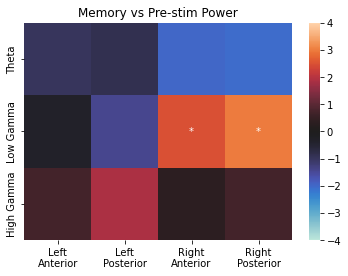

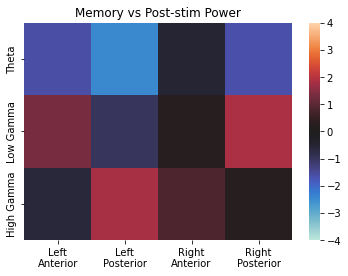

In [ ]:
import seaborn as sns

xs = ['Pre', 'Change', 'Post']
for i in range(3):
    fig, ax = plt.subplots()
    sns.heatmap(tvals_grid[i].T, 
        xticklabels=['Left\nAnterior', 'Left\nPosterior', 'Right\nAnterior', 'Right\nPosterior'],
        yticklabels=['Theta', 'Low Gamma', 'High Gamma'],
        center=0,
        vmax=4, vmin=-4,
        annot=np.where(pvals_after[i].T < 0.05, '*', ''),
        fmt='',
        ax=ax)
    ax.set_title(f'Memory vs {xs[i]}-stim Power')

In [ ]:
import statsmodels.formula.api as smf
from IPython.display import display

for chan in hip_chans:
    print(chan +":")
    df_filtered = power_mem_trial[power_mem_trial['Channel'] == chan]
    x='pre'
    formula = f"Memory_Score ~ Theta_log_{x} + GammaLow_log_{x} + GammaHigh_log_{x}"
    model = smf.ols(formula, df_filtered)
    results = model.fit()
    display(results.summary())

LHip1 - LHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                 -0.122
Method:                 Least Squares   F-statistic:                    0.3819
Date:                Wed, 16 Nov 2022   Prob (F-statistic):              0.768
Time:                        06:57:14   Log-Likelihood:                -36.527
No. Observations:                  18   AIC:                             81.05
Df Residuals:                      14   BIC:                             84.61
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.7104     14.883      0.585      0.568     -23.210      40.630
Theta_log_pre        -1.0858      1.117     -0.972      0.348      -3.482       1.310
GammaLow_log_pre     -1.1742      3.497     -0.336      0.742      -8.675       6.327
GammaHigh_log_pre     2.0998      3.001      0.700      0.496      -4.337       8.537
==============================================================================
Omnibus:                        1.408   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.090
Skew:                           0.382   Prob(JB):                        0.580
Kurtosis:                       2.068   Cond. No.                         489.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

LHip3 - LHip4:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.499
Date:                Wed, 16 Nov 2022   Prob (F-statistic):              0.258
Time:                        06:57:14   Log-Likelihood:                -34.727
No. Observations:                  18   AIC:                             77.45
Df Residuals:                      14   BIC:                             81.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            14.0724     16.659      0.845      0.412     -21.658      49.803
Theta_log_pre        -1.0173      1.176     -0.865      0.402      -3.539       1.505
GammaLow_log_pre     -3.3859      2.398     -1.412      0.180      -8.529       1.757
GammaHigh_log_pre     4.6396      2.498      1.857      0.084      -0.718       9.997
==============================================================================
Omnibus:                        0.209   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.407
Skew:                          -0.041   Prob(JB):                        0.816
Kurtosis:                       2.268   Cond. No.                         608.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RHip1 - RHip2:


c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     7.969
Date:                Wed, 16 Nov 2022   Prob (F-statistic):            0.00242
Time:                        06:57:14   Log-Likelihood:                -27.487
No. Observations:                  18   AIC:                             62.97
Df Residuals:                      14   BIC:                             66.54
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            37.1689     10.130      3.669      0.003      15.441      58.897
Theta_log_pre        -1.0308      0.520     -1.981      0.068      -2.147       0.085
GammaLow_log_pre      3.4928      1.397      2.500      0.025       0.496       6.490
GammaHigh_log_pre     0.5300      1.664      0.318      0.755      -3.039       4.099
==============================================================================
Omnibus:                        1.285   Durbin-Watson:                   2.387
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                0.611
Skew:                           0.451   Prob(JB):                        0.737
Kurtosis:                       2.973   Cond. No.                         546.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\seand\eeg_proj\venv\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


RHip3 - RHip4:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Memory_Score   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     5.277
Date:                Wed, 16 Nov 2022   Prob (F-statistic):             0.0169
Time:                        06:57:14   Log-Likelihood:                -23.279
No. Observations:                  15   AIC:                             54.56
Df Residuals:                      11   BIC:                             57.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            59.3278     14.969      3.963      0.002      26.381      92.274
Theta_log_pre        -1.8979      0.931     -2.038      0.066      -3.947       0.152
GammaLow_log_pre      6.1267      2.060      2.975      0.013       1.593      10.660
GammaHigh_log_pre     0.9564      1.349      0.709      0.493      -2.013       3.926
==============================================================================
Omnibus:                        1.278   Durbin-Watson:                   2.555
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                0.755
Skew:                          -0.534   Prob(JB):                        0.686
Kurtosis:                       2.743   Cond. No.                         698.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Final Grid

In [ ]:
import importlib
import stats_pipeline
importlib.reload(stats_pipeline)

<module 'stats_pipeline' from 'c:\\Users\\seand\\eeg_proj\\ecog\\stats_pipeline.py'>

$FREQ_log_pre Memory_Score
RHip1 - RHip2 GammaLow: r = 0.6927075257974956, p = 0.0014397869735771997
RHip1 - RHip2 GammaHigh: r = 0.7167178592835314, p = 0.0008174535977196465
RHip3 - RHip4 GammaLow: r = 0.6388748889752464, p = 0.010353054438506521
RHip3 - RHip4 GammaHigh: r = 0.5338649873431343, p = 0.040385282279083716
$FREQ_log_pre Prev_Trio
$FREQ_log_pre Next_Trio
RHip1 - RHip2 GammaLow: r = 0.5632056131590767, p = 0.007850045880187262
$FREQ_log_chg Memory_Score
$FREQ_log_chg Prev_Trio
$FREQ_log_chg Next_Trio
$FREQ_log_post Memory_Score
LHip3 - LHip4 Theta: r = -0.5084692755224302, p = 0.031185527236468037
RHip1 - RHip2 GammaLow: r = 0.485781177341055, p = 0.04097030990591263
RHip1 - RHip2 GammaHigh: r = 0.5651886531483296, p = 0.014516599603612896
$FREQ_log_post Prev_Trio
$FREQ_log_post Next_Trio
RHip1 - RHip2 GammaLow: r = 0.5561148974663989, p = 0.008848616455584412


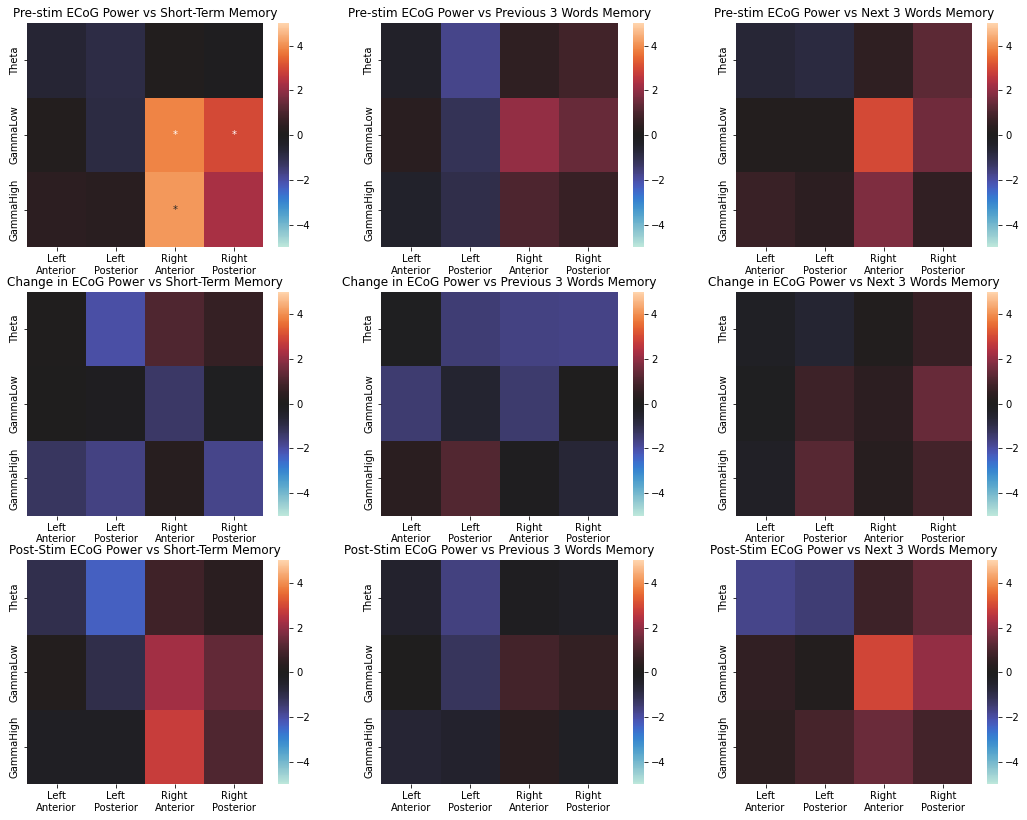

In [ ]:
from stats_pipeline import make_heatmap_linreg
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(18, 14)
xs = ['$FREQ_log_pre', '$FREQ_log_chg', '$FREQ_log_post']
xlabels = ['Pre-stim ECoG Power', 'Change in ECoG Power', 'Post-Stim ECoG Power']
ys = ['Memory_Score', 'Prev_Trio', 'Next_Trio']
ylabels = ['Short-Term Memory', 'Previous 3 Words Memory', 'Next 3 Words Memory']
for i in range(3):
    for j in range(3):
        df = power_mem_trial if j == 0 else power_mem_3
        print(xs[i], ys[j])
        make_heatmap_linreg(df, xs[i], ys[j], ['Theta', 'GammaLow', 'GammaHigh'], xlabels[i], ylabels[j], ax=axs[i][j])

# Effect of Stim on Power

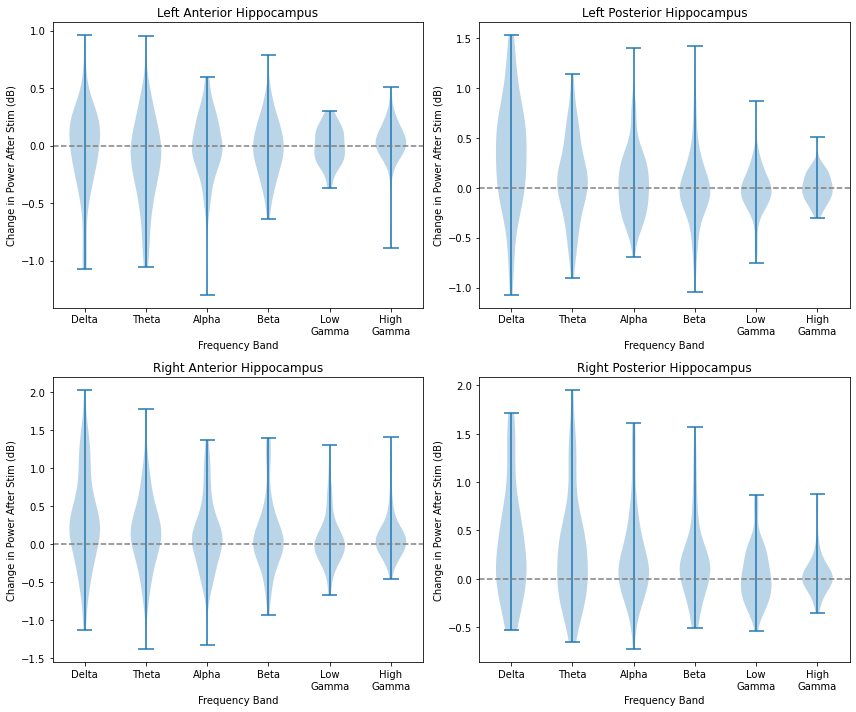

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
freq_labels = list(map(lambda freq: freq[len('Gamma'):]+'\nGamma' if freq.startswith('Gamma') else freq, freqs))
for i, chan in enumerate(hip_chans):
    ax = axs[i // 2, i % 2]
    power_for_chan = power_and_mem[power_and_mem['Channel'] == chan]
    ax.violinplot([power_for_chan[freq + '_log_chg'] for freq in freqs])
    ax.set_xticks(range(1,7), freq_labels)
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Change in Power After Stim (dB)')
    ax.axhline(0, linestyle='--', c='gray')
    ax.set_title(['Left Anterior Hippocampus', 'Left Posterior Hippocampus', 'Right Anterior Hippocampus', 'Right Posterior Hippocampus'][i])
fig.tight_layout()

In [ ]:
from seaborn import heatmap

pts_w_hip = [100, 103, 105, 109, 110, 111, 112, 113, 115]
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
for i in range(8):
    power_for_pt = power_and_mem[power_and_mem['ID'] == pts_w_hip[i]]
    t_vals = []
    for chan in ['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4']:
        power_for_chan = power_for_pt[power_for_pt['Channel'] == chan]
        for freq in freqs:
            # TODO think about this
            t = power_for_chan[freq+'_log_chg'].mean() / power_for_chan[freq+'_log_chg'].std()
            t_vals.append({'Frequency': freq, 'Channel': chan, 't': t})
    df_tvals = pd.DataFrame(t_vals)
    try:
        df_crosstab = pd.crosstab(df_tvals['Frequency'], df_tvals['Channel'], df_tvals['t'], aggfunc=np.mean)
        axs[i//3, i%3].set_title(pts_w_hip[i])
        heatmap(df_crosstab, ax=axs[i//3, i%3], center=0)
    except:
        pass

# Delay Memory

In [ ]:
pm_filtered = power_mem_3[power_mem_3['Channel'] == 'RHip1 - RHip2']
plt.scatter(pm_filtered['GammaLow_log_pre'], pm_filtered['Prev_Trio'])